### Labb 2 

- a) Börja med att ladda ned datasetet Dogs vs Cats från Kaggle. Extrahera den och lägg den i din labfolder,
glöm inte att lägga till den till .gitignore.

-----


## b)

 - Läs in 10 bilder slumpmässigt, plotta dem och extrahera deras labels och skriv ut i titeln.


In [151]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os # Used for interacting with the operating system. Essential for file and directory operations.
import random
from PIL import Image # Part of the Pillow library, used for opening, manipulating, and saving many different image file formats.

In [152]:
# Set the directory path where the images are stored.
source_dir = "original_data/train/train"

# List all files in the specified directory and filter to include only '.jpg' files.
image_files = [f for f in os.listdir(source_dir) if f.endswith('.jpg')]

# Randomly select 10 images from the list of jpg files.
selected_images = random.sample(image_files, 10)

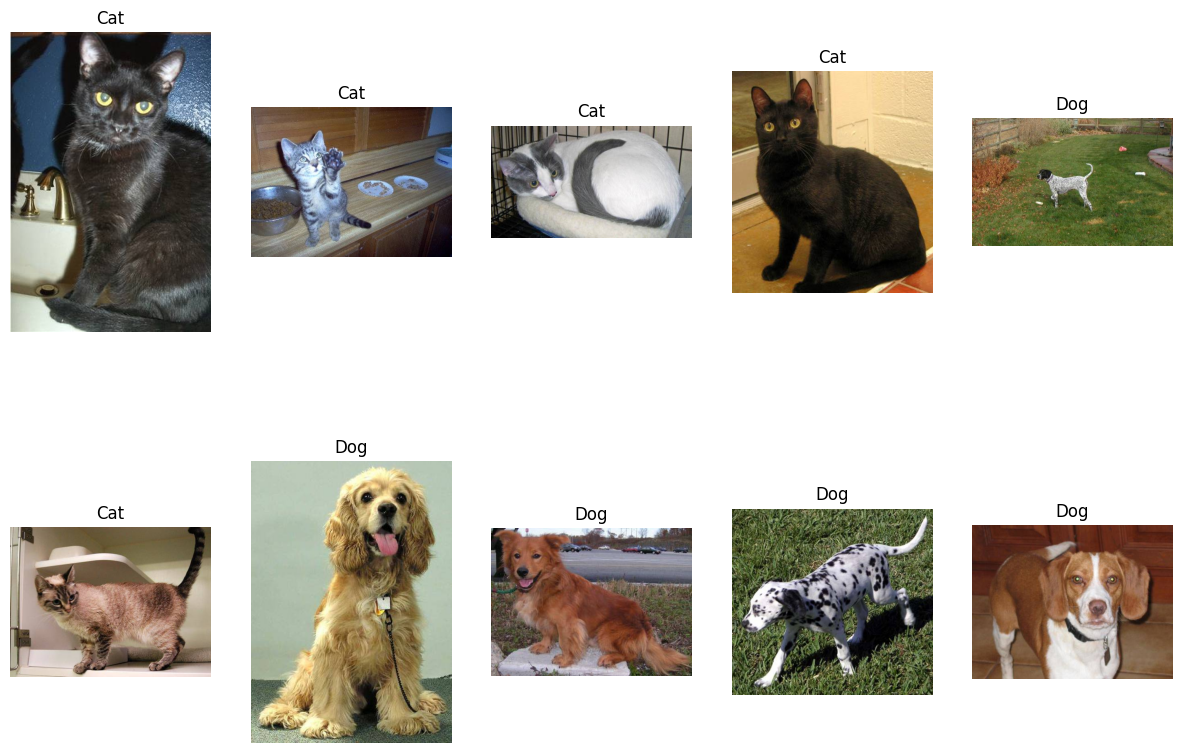

In [153]:
plt.figure(figsize=(15, 10))

# Loop through each selected image file.
for i, image_file in enumerate(selected_images):
    # Open the image file using the PIL library and join path components.
    img = Image.open(os.path.join(source_dir, image_file))
    
    # Determine the label ('Cat' or 'Dog') based on the presence of 'cat' in the file name.
    label = 'Cat' if 'cat' in image_file else 'Dog'
    
    
    plt.subplot(2, 5, i + 1)
    plt.imshow(img) # Display the image in the current subplot.
    plt.title(label) # Set the title of the subplot to the label of the image.
    plt.axis('off')

plt.show()

------

## c)

- Skapa folderstrukturen nedan med Python

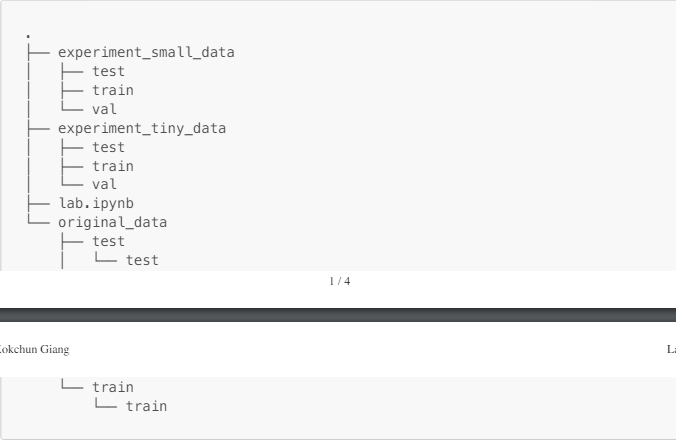     ---->      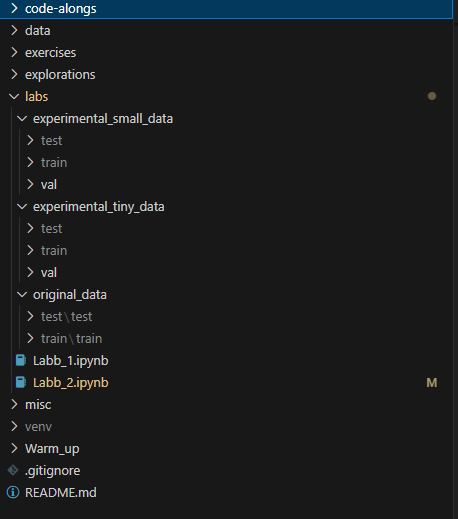

-----

### d)

- d) Nu ska du göra train|val|test split med följande splits:
    - experiment_small
    - train - 1600 (800 dogs, 800 cats)
    - val - 400 (200 dogs, 200 cats)
    - test - 500 (250 dogs, 250 cats)

Det är inte så farligt om det inte blir exakt balanserade dataset.
Det är viktigt att du samplar slumpmässigt utan replacement från originaldatasetet under respektive
experiment. Spara datan i deras respektive mappar. (**)


Nedan kod används för att distribuera bildfiler till tränings-, validerings- och testset. Det säkerställer att bilderna fördelas slumpmässigt utan replacement mellan datamängderna.

Använder shutil för att flytta bildfiler.
   
- base_dir: Huvudsökväg där datamängderna kommer att lagras.
- categories: Kategorier av bilder, exempelvis 'dogs' och 'cats'.
- sets: Typ av datamängd, dvs. 'train', 'val', och 'test'.
- split_counts: Hur många bilder som ska till varje kategori och set.
- Skapar nödvändiga undermappar för varje kategori inom varje datamängdstyp.
- Funktionen check_if_distribution_needed kontrollerar om folderna redan innehåller det den ska.
- Funktionen distribute_files blandar och fördelar bilderna till de angivna mapparna. Detta säkerställer att varje bild endast används en gång.

Har manuellt kontrollerat så bilderna som används i train test val inte finns kvar i original mappen.

In [154]:
import os
import shutil
import random

# Set the directory for data storage
base_dir = "experimental_small_data"
source_dir = "original_data/train/train"  # Ensure this path is correct

# Specify categories and datasets
categories = ['dogs', 'cats']
sets = ['train', 'val', 'test']

# Define the number of pictures for each set and category
split_counts = {
    'train': {'dogs': 800, 'cats': 800},
    'val': {'dogs': 200, 'cats': 200},
    'test': {'dogs': 250, 'cats': 250}
}

# Create necessary folders for each category in each dataset
for set in sets:
    for category in categories:
        path = os.path.join(base_dir, set, category)
        os.makedirs(path, exist_ok=True)

def check_if_distribution_needed():
    # Check if the distribution has already been done
    for set in sets:
        for category in categories:
            path = os.path.join(base_dir, set, category)
            if len(os.listdir(path)) != split_counts[set][category]:
                return True
    return False

def distribute_files():
    if not check_if_distribution_needed():
        print("Distribution already completed. No further action taken.")
        return

    # Collect all files by category and shuffle them to ensure random distribution
    files = {category: [f for f in os.listdir(source_dir) if category[:-1] in f] for category in categories}
    for category in categories:
        random.shuffle(files[category])

    # Distribute the files to their respective folders
    for set in sets:
        for category in categories:
            amount = split_counts[set][category]
            selected_files = files[category][:amount]
            files[category] = files[category][amount:]  

            for file in selected_files:
                shutil.move(os.path.join(source_dir, file), os.path.join(base_dir, set, category, file))

distribute_files()  




Distribution already completed. No further action taken.


Nedan kod kontrollerar vad sets innehåller. sets är då train|test|val mapparna.

In [155]:
for set in sets:
    for category in categories:
        path = os.path.join(base_dir, set, category)
        count = len(os.listdir(path))
        print(f'{set} {category}: {count} files')



train dogs: 800 files
train cats: 800 files
val dogs: 200 files
val cats: 200 files
test dogs: 250 files
test cats: 250 files


----------

### e) 
Läs in dataseten från experiment_small, experiment_tiny (BONUS) och plocka ut labelsvektorer, som
ska vara one-hot encoded med 0 och 1.
- plotta några bilder med deras respektive labels och kontrollera att det är korrekt.
- skapa lämplig plot för att kontrollera att dataseten är balanserade
- skapa lämplig plot för att kontrollera att dataseten är slumpade, dvs inte ex [0, 0, ... 0, 1, 1, ..., 1]


Hämta en lista av filnamn och slumpa listan
- Funktionen samlar filnamn för alla JPEG-bilder i specificerade mappar och associerar varje bild med en label baserat på filnamnet (dog eller cat).
- Listan med filnamn slumpas för att garantera en bra blandning.
- Bilderna laddas och storleken ändras till 150x150 pixlar genom list comprehension.
- Labels konverteras till ett format med one-hot-kodning.
- Bilderna och labels omvandlas till numpy-arrayer.


In [156]:
def prepare_and_load_data(set_type, num_images=100):
    data_path = os.path.join(base_dir, set_type)
    image_files = []
    labels = []

    # Create a list with paths and labels
    for category in categories:
        category_path = os.path.join(data_path, category)
        files = os.listdir(category_path)
        for file in files:
            if file.endswith('.jpg'):
                image_files.append((os.path.join(category_path, file), 1 if category == 'dogs' else 0))

    # shuffle list 
    random.shuffle(image_files)

    # Use list comprehension to read pics and convert labels to one-hot encoding
    images = [np.array(Image.open(file_path).resize((150, 150))) / 255.0 for file_path, _ in image_files[:num_images]]
    labels = [[1, 0] if label == 1 else [0, 1] for _, label in image_files[:num_images]]

    # Convert to numpy arrays 
    images = np.array(images)
    labels = np.array(labels)
    return images, labels

train_images, train_labels = prepare_and_load_data('train', 160)
val_images, val_labels = prepare_and_load_data('val', 50)
test_images, test_labels = prepare_and_load_data('test', 50)



Plotta några bilder med deras labels
- Labels ser korrekt ut.

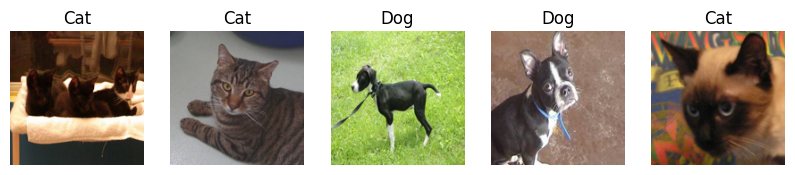

In [157]:

plt.figure(figsize=(10, 2))
for i in range(5): 
    plt.subplot(1, 5, i + 1)
    plt.imshow(train_images[i])
    plt.title('Dog' if train_labels[i][0] == 1 else 'Cat')
    plt.axis('off')
plt.show()




Skapa en plot för att se att dataseten är balanserade

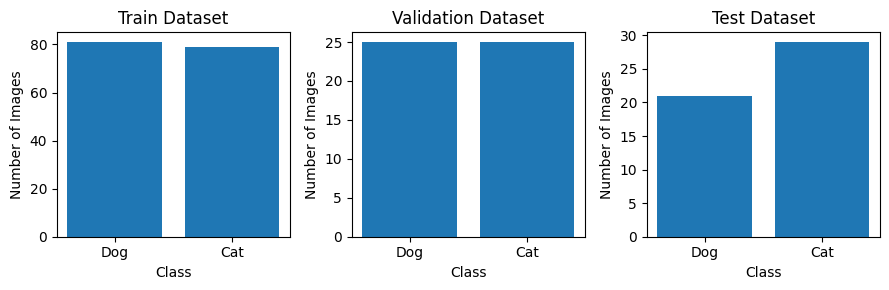

In [158]:

plt.figure(figsize=(9, 3))
dataset_labels = ['Train', 'Validation', 'Test']
all_labels = [train_labels, val_labels, test_labels]

for i, labels in enumerate(all_labels):
    # Count number of dogs and cats
    dog_count = np.sum([label[0] for label in labels])
    cat_count = np.sum([label[1] for label in labels])
    plt.subplot(1, 3, i + 1)
    plt.bar(['Dog', 'Cat'], [dog_count, cat_count])
    plt.title(f'{dataset_labels[i]} Dataset')
    plt.xlabel('Class')
    plt.ylabel('Number of Images')

plt.tight_layout()
plt.show()


Skapa en plot för att kontrollera att dataseten är slumpade
- Genom plotten så ser man tydligt att datasetet är slumpat.

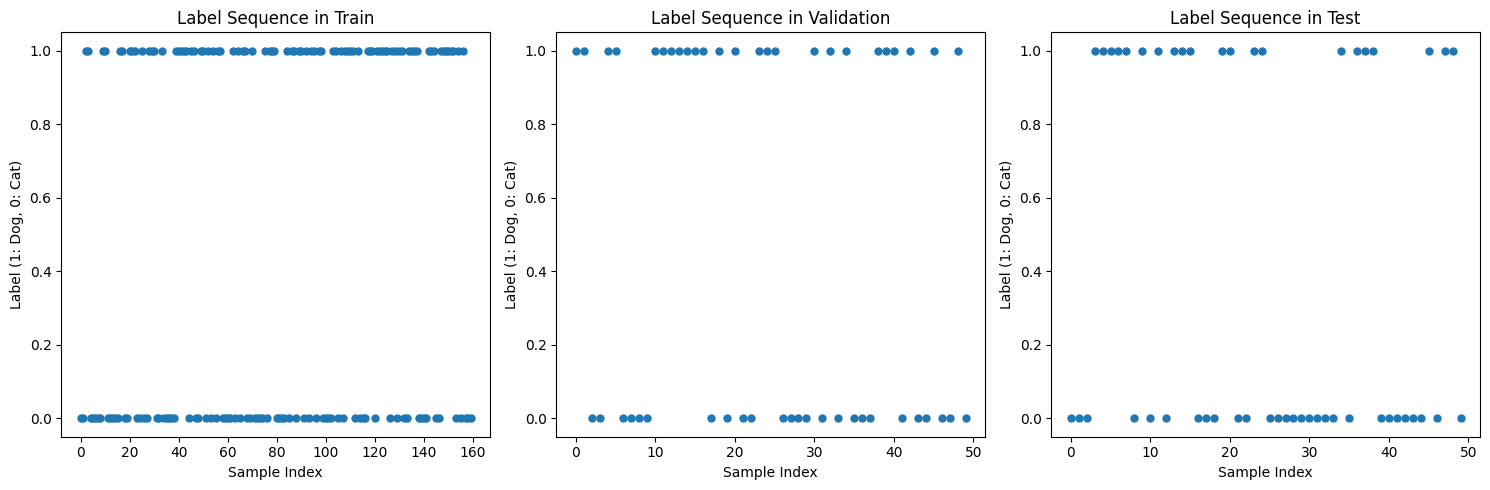

In [159]:
plt.figure(figsize=(15, 5))
for i, labels in enumerate(all_labels):
    label_seq = [label[0] for label in labels] 
    plt.subplot(1, 3, i + 1)
    plt.plot(label_seq, marker='o', linestyle='', markersize=5)
    plt.title(f'Label Sequence in {dataset_labels[i]}')
    plt.xlabel('Sample Index')
    plt.ylabel('Label (1: Dog, 0: Cat)')

plt.tight_layout()
plt.show()


-----